In [28]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_pickle("../data/train_query.pickle")
df.head()b

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
423,14710443,15837,trocador de comoda,1,3,trocador de comoda reto,moveis trocador comoda enxoval henrique,2017-08-24 15:59:44,130.50000,609.0,1,1,126,7,Bebê
11878,5013802,303463,necessaire box futebol,1,19,Necessaire box masculina personalizada Dia dos...,dia pais,2019-07-21 16:07:32,28.36000,81.0,1,8,98,15,Lembrancinhas
34479,8000979,3637678,lembrancinhas de eva para igreja,1,33,Mini Porta-retrato com mensagem Louvarei ao Se...,festividades religiosas/igreja,2018-09-08 18:38:22,12.15000,8.0,1,10,355,1,Lembrancinhas
8489,4875844,5965170,almofada para cadeira,1,0,Almofada Para Cadeira De Balanço Do Papai,almofada cadeira balanco,2018-05-13 17:55:56,169.81001,6.0,1,1,186,0,Decoração
31176,6285211,7327649,quanto custa caneca personalizada,1,0,Caneca personalizada,caneca personalizada caneca lembrancinhas mono...,2017-08-20 18:59:02,17.50000,9.0,1,4,733,0,Lembrancinhas


# Análise descritiva das queries

In [21]:
query_counts = df["query"].value_counts()
query_counts.describe()

count    5866.000000
mean        4.587794
std         6.815524
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       106.000000
Name: query, dtype: float64

In [22]:
df["position"].describe()

count    26912.000000
mean        16.906622
std         11.620276
min          0.000000
25%          6.000000
50%         16.000000
75%         27.000000
max         38.000000
Name: position, dtype: float64

Comparando com os dados de posição com os resultados da busca, vemos que
talvez tenhamos algumas inconsistências. Se até 25% das queries possuem apenas
um resultado, seria esperado que até esse mesmo percentual tivessemos resultados
de 0 posição (se o resultado é único ele também deve ser o primeiro).

Essa discrepancia pode ser originada da divisão dos dados entre treinamento e
teste. Porém, essa hipótese me parece pouco provável. O mais provável seria
que os nossos dados são apenas uma amostra dos resultados das queries agregadas.
Com isso, o fato de uma query aparecer pouco não é indicativo dela ter poucos
resultados, mas sim dela ser realizada poucas vezes.

In [7]:
query_counts.shape[0]

5866

In [8]:
(query_counts >= 10).sum()

559

In [13]:
query_with_more_results = query_counts.index[(query_counts >= 10)]
results_from_selc_queries = df["query"].isin(query_with_more_results)
results_from_selc_queries.mean()

0.41152645659928655

Com isso vemos que menos que 10% das queries possuem mais de 10 resultados.
Esse fator pode prejudicar a nossa capacidade de avaliar a recuperação de 10
resultados a partir da informação de uma query. Mas apesar de compreender uma
pequena parcela dos dados, essas queries representam mais que 40% dos dados.

Ainda assim, perder quase 60% dos resultados de query não é um resultado muito
bom.

In [20]:
# fazendo a diferença entre as distribuições das catgorias nos dados completos
# e nos dados com apenas as queries mais frequentes.
(df[results_from_selc_queries]["category"].
 value_counts(normalize=True).
 sort_index().mul(100).round(2).
 sub(df["category"].
     value_counts(normalize=True).
     sort_index().mul(100).round(2)))

Bebê                  3.21
Bijuterias e Jóias   -0.82
Decoração            -7.00
Lembrancinhas         7.65
Outros               -1.53
Papel e Cia          -1.49
Name: category, dtype: float64

Um impacto adicional é a mudança na distribuição das categorias. Essa mudança
acaba sendo mais acentuada para as categorias de lembrancinhas e decoração com
uma diferença de aproximadamente 7p.p. em cada uma. Com isso, talvez seja
interessante adicionar os dados de teste aos dados de treinamento para
aumentar a quantidade de nossos dados e com isso, talvez aumentar a proporção
total de dados que tenham queries associadas a pelo menos 10 resultados. Por
hora vamos ser conservadores e manter os datasets separados. Dependendo da
técnica de ranqueamento utilizado os dados de testes ainda podem ser úteis
para avaliar a capacidade de generalização dos sistema de recomendação.

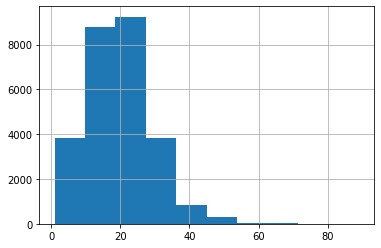

In [29]:
df["query"].apply(len).hist()
plt.show()

In [39]:
df[df["query"].apply(len) <= 2]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
35036,4587169,9485878,l,1,1,Convite L.O.L Surprise com Envelope,l.o.l surprise convites,2018-02-11 14:15:02,11.34,7.0,1,16,106,0,Papel e Cia
22539,9877776,5345324,jw,1,26,Caneca Congresso Internacional Brazil - O amor...,presentes jw congresso,2019-06-12 09:33:08,45.36,606.0,0,0,548,33,Lembrancinhas


Ao avaliar a distribuição do tamanho das queries vemos que não há grandes
problemas com as queries. Sua média é próxima de 20 e não temos nenhum registro
de query cujo tamanho seja 0, o que seria uma query vazia. Porém foram
identificados duas queries com tamanho menor ou igual a 2 que parecem que foram
erros de digitação. Para melhorar a qualidade dos dados esses registros serão
eliminados.

In [44]:
df = df.loc[~(df["query"].apply(len) <= 2)]
df[df["query"].apply(len) <= 2]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
